




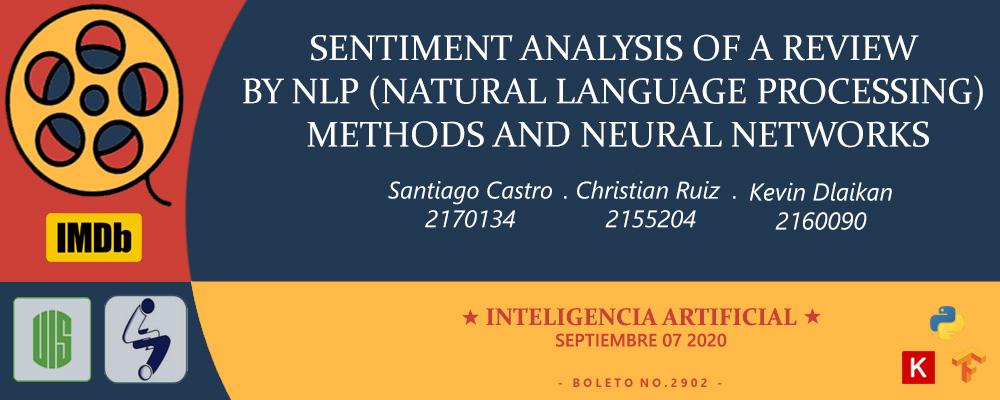


## **Cargar almacenamiento de drive.**

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
%cd '/content/drive/My Drive/Universidad /Inteligencia Artifical/PROYECTO/ProyectoIA' 

PATH = '/content/drive/My Drive/Universidad /Inteligencia Artifical/PROYECTO/ProyectoIA' 
!pwd


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/Universidad /Inteligencia Artifical/PROYECTO/ProyectoIA
/content/drive/My Drive/Universidad /Inteligencia Artifical/PROYECTO/ProyectoIA


## Importar de librerias

In [ ]:


#Importación de librerías a utilizar
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import re
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import *



#Forzar uso de tensorflow v2
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


## Definir funciones como limpieza de texto, padding de las review etc...

In [ ]:
# Limpiando todo el dataset
def limpiarTexto(texto):
    soup = BeautifulSoup(texto, "html.parser")  #Removiendo las etiquetas HTML
    review = soup.get_text()
    review = re.sub('\[[^]]*\]', ' ', review)
    review = re.sub('[^a-zA-Z]', ' ', review)
    review = review.lower()  
    return review

#Gráficas resultados del entrenamiento
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

#Hace los padding de las review con respecto a un pad_size (La review con mayor longitud)
def padded_batch(data, pad_size=64):
    if len(data) > pad_size:
        return data[:pad_size]
    else:
        return np.r_[data, np.zeros(pad_size - len(data))]

# Obtiene un vector de resultados y los convierte en 0 o 1 (positivo o negativo)
def getNumResult(results):
  real_results = []
  for result in results:
    if result >=0.5 :
      result =1
    else:
      result =0
    real_results.append(result)
  return real_results

def getSentiment(val):
  rst = 'La opinión es negativa'
  if (val >=0.5):
    rst = 'La opinión es positiva'
  return rst



# Carga del dataSets y el encoding 

In [ ]:
#Descarga del encoding

#info contiene el encoding 
#DataSet de tensorFlow
dataset , info = tfds.load('imdb_reviews/subwords32k', with_info=True,
                          as_supervised=True)

# Data set en csv.
df = pd.read_csv('IMDB Dataset.csv')
print(df.shape) #Imprimir cuantas filas y columnas tiene el dataset.
df.head(5)

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords32k/1.0.0.incompleteFY1S0U/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords32k/1.0.0.incompleteFY1S0U/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords32k/1.0.0.incompleteFY1S0U/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords32k/1.0.0. Subsequent calls will reuse this data.
(50000, 2)


review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive

## **Preprocesamiento del dataSet**

In [ ]:
# Se categoriza la variable sentimientos con LabelEncoder Positive = 1 Negative = 0
from sklearn.preprocessing import LabelEncoder

encoder_y = LabelEncoder()
df['sentiment'] = encoder_y.fit_transform(df.sentiment)
df.head(3)

review  sentiment
0  One of the other reviewers has mentioned that ...          1
1  A wonderful little production. <br /><br />The...          1
2  I thought this was a wonderful way to spend ti...          1

## **Limpiado de Datos**

In [ ]:
#Aplicar la función limpiarTexto a cada fila de la columna "review" del dataset.
df.review = df['review'].apply(limpiarTexto)


In [ ]:
#df.to_csv (PATH+"/nuevoDataSetLimpio2.csv", index = False, header=True)

In [ ]:
#Cargar dataSet limpio
#Esto se hace porque guardamos el dataset luego de ejecutar la funcion limpiartexto() debido 
#a que el proceso de limpiado dura más de media hora en ejecutarse.

df = pd.read_csv('nuevoDataSetLimpio2.csv')
df.head(4)

review  sentiment
0  one of the other reviewers has mentioned that ...          1
1  a wonderful little production  the filming tec...          1
2  i thought this was a wonderful way to spend ti...          1
3  basically there s a family where a little boy ...          0

# Carga del encoder

In [ ]:
encoder = info.features['text'].encoder
print('Vocabulary size: {}'.format(encoder.vocab_size))

Vocabulary size: 32650


## Ejemplo de codificación

In [ ]:
sample_string = 'Hello TensorFlow.'

encoded_string = encoder.encode(sample_string)
print('Encoded string is {}'.format(encoded_string))

original_string = encoder.decode(encoded_string)
print('The original string: "{}"'.format(original_string))

Encoded string is [16092, 31789, 642, 9656, 32513, 32440]
The original string: "Hello TensorFlow."


In [ ]:
assert original_string == sample_string
for index in encoded_string:
  print('{} ----> {}'.format(index, encoder.decode([index])))

16092 ----> Hello 
31789 ----> Tens
642 ----> or
9656 ----> Flo
32513 ----> w
32440 ----> .


## **Padding del dataSet**

In [ ]:
# Codificamos el dataset y hacemos un paggind con ceros, con respecto a la review más larga
data = np.array([encoder.encode(review) for review in df.review])
print(data)
padd_size = len(np.max(data))
print(padd_size)
data = np.array([padded_batch(dt, padd_size) for dt in data])


[list([42, 6, 1, 98, 2712, 51, 1528, 13, 132, 194, 3314, 32426, 32426, 32426, 11041, 32426, 612, 35, 249, 34, 12361, 32426, 32426, 47, 29, 681, 32426, 32426, 20, 14, 8, 710, 65, 888, 21, 100, 1, 109, 218, 13, 4259, 100, 53, 11041, 32426, 18, 108, 9788, 5, 30564, 32426, 199, 6, 1386, 32426, 32426, 67, 364, 10, 310, 44, 1, 1226, 1023, 32426, 32426, 2699, 234, 32426, 32426, 14, 8, 33, 4, 173, 22, 1, 15920, 3058, 49, 19970, 32426, 32426, 14, 173, 3192, 78, 11252, 21, 13182, 7, 3858, 32426, 32426, 585, 49, 1386, 32426, 32426, 108, 8, 1493, 7866, 32426, 32426, 10, 1, 570, 398, 6, 1, 1226, 15, 8, 671, 11041, 32426, 20, 13, 8, 1, 18041, 32426, 410, 7, 1, 3139, 24756, 32426, 14971, 3711, 1798, 5903, 6654, 11753, 1680, 32426, 32426, 15, 3206, 1726, 26, 12980, 15795, 107, 2200, 32426, 32426, 41, 8697, 3848, 6, 1, 2025, 133, 45, 1, 17596, 31, 6044, 22001, 32426, 5, 600, 222, 7268, 32509, 32426, 32426, 50, 29096, 3036, 8, 33, 438, 26, 1, 12151, 32426, 32426, 4343, 1270, 8, 560, 7, 2640, 32426, 3242

# División del DataSet

In [ ]:
# Tomamos la columna sentiment para tener la columna de labels
target = df.sentiment.values
target = np.array(target)
target.shape = (len(target),1)


In [ ]:
#Creamos el train_dataset y test_dataset como objetos tipo Dataset de tensorflow
train_dataset = tf.data.Dataset.from_tensor_slices((data[:25000,:], target[:25000]))
test_dataset = tf.data.Dataset.from_tensor_slices((data[25000:, :], target[25000:]))

# Train y test del dataset cargado desde TensorFlow
train_dataset_TF, test_dataset_TF = dataset['train'], dataset['test']

X_test, y_test = data[25000:, :],target[25000:]

print('Train:    {}'.format(train_dataset))
print('Test:     {}'.format(test_dataset))
#print('Validate: {}'.format(validate_dataset))

Train:    <TensorSliceDataset shapes: ((412,), (1,)), types: (tf.float64, tf.int64)>
Test:     <TensorSliceDataset shapes: ((412,), (1,)), types: (tf.float64, tf.int64)>


In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [ ]:
#Creamos lo conjuntos de ingreso a las red del tamañao de BATCH_SIZE
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE)
test_dataset = test_dataset.padded_batch(BATCH_SIZE)

#Creamos lo conjuntos de ingreso a las red del tamañao de BATCH_SIZE (DataSet TensorFlow)
train_dataset_TF = train_dataset_TF.shuffle(BUFFER_SIZE)
train_dataset_TF = train_dataset_TF.padded_batch(BATCH_SIZE)
test_dataset_TF = test_dataset_TF.padded_batch(BATCH_SIZE)


print(train_dataset, test_dataset)

<PaddedBatchDataset shapes: ((None, 412), (None, 1)), types: (tf.float64, tf.int64)> <PaddedBatchDataset shapes: ((None, 412), (None, 1)), types: (tf.float64, tf.int64)>


# Creación del modelo

* Creamos el modelo 'Sequiential' que comienza con una capa de Embedding. 
El embedding almacena un vector por palabra, lo que hace que al ser llamado convierte las secuencias de índices de palabras en secuencias de vectores. Estos vectores se van entrenando y con los sufucientes datos de entrenamiento, las palabras con significados similares presentan vectores similares.
* Se crea una capa recurrente LSTM para un mejor aprendizaje del contexto de las reviews gracias a su "aprendizaje a largo plazo." 

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          2089600   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 2,163,969
Trainable params: 2,163,969
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])


# Entrenamiento del modelo

In [ ]:
#Force el uso de GPU para el entrenamiento.
with tf.device('/gpu:0'):
  history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=test_dataset)

Epoch 1/10
391/391 [==============================] - 26s 67ms/step - loss: 0.6579 - accuracy: 0.5493 - val_loss: 0.5200 - val_accuracy: 0.7726
Epoch 2/10
391/391 [==============================] - 26s 66ms/step - loss: 0.3538 - accuracy: 0.8482 - val_loss: 0.3296 - val_accuracy: 0.8522
Epoch 3/10
391/391 [==============================] - 26s 66ms/step - loss: 0.2235 - accuracy: 0.9131 - val_loss: 0.3093 - val_accuracy: 0.8598
Epoch 4/10
391/391 [==============================] - 26s 66ms/step - loss: 0.1662 - accuracy: 0.9388 - val_loss: 0.3111 - val_accuracy: 0.8750
Epoch 5/10
391/391 [==============================] - 26s 66ms/step - loss: 0.1236 - accuracy: 0.9582 - val_loss: 0.4437 - val_accuracy: 0.8566
Epoch 6/10
391/391 [==============================] - 26s 66ms/step - loss: 0.0913 - accuracy: 0.9719 - val_loss: 0.4432 - val_accuracy: 0.8589
Epoch 7/10
391/391 [==============================] - 26s 66ms/step - loss: 0.0652 - accuracy: 0.9814 - val_loss: 0.4853 - val_accuracy:

In [ ]:
# Guardar el Modelo 
!pip install -q pyyaml h5py 
#model.save(PATH+'/modelSimpleCleanText32K2525.h5')

# Cargar el modelo entrenado

model_simple_Data = keras.models.load_model(PATH+'/modelSimpleCleanText32K2525.h5')


In [ ]:
# Volvemos a crear el modelo para dejarlo sin entrenar
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
#Force el uso de GPU para el entrenamiento. Entrenamiento con DatSet TF
with tf.device('/gpu:0'):
  history_TF = model.fit(train_dataset_TF,
                    epochs=10,
                    validation_data=test_dataset_TF)
  

Epoch 1/10
391/391 [==============================] - 57s 145ms/step - loss: 0.6501 - accuracy: 0.5548 - val_loss: 0.5220 - val_accuracy: 0.6712
Epoch 2/10
391/391 [==============================] - 56s 144ms/step - loss: 0.3270 - accuracy: 0.8586 - val_loss: 0.3307 - val_accuracy: 0.8460
Epoch 3/10
391/391 [==============================] - 57s 145ms/step - loss: 0.1942 - accuracy: 0.9284 - val_loss: 0.3149 - val_accuracy: 0.8748
Epoch 4/10
391/391 [==============================] - 56s 144ms/step - loss: 0.1372 - accuracy: 0.9524 - val_loss: 0.3984 - val_accuracy: 0.8535
Epoch 5/10
391/391 [==============================] - 57s 145ms/step - loss: 0.0822 - accuracy: 0.9756 - val_loss: 0.3646 - val_accuracy: 0.8664
Epoch 6/10
391/391 [==============================] - 56s 143ms/step - loss: 0.0591 - accuracy: 0.9838 - val_loss: 0.3961 - val_accuracy: 0.8671
Epoch 7/10
391/391 [==============================] - 56s 144ms/step - loss: 0.0642 - accuracy: 0.9840 - val_loss: 0.4129 - val_ac

In [ ]:
# Guardar el Modelo 

#model.save(PATH+'/modelDataSetTF2.h5')

# Cargar el modelo entrenado

model_TF_Data = keras.models.load_model(PATH+'/modelDataSetTF2.h5')

# Resultados

In [ ]:
test_loss, test_acc = model_simple_Data.evaluate(test_dataset)

print('Test Loss plain text dataset: {}'.format(test_loss))
print('Test Accuracy plain text dataset: {}\n'.format(test_acc))

test_loss, test_acc = model_TF_Data.evaluate(test_dataset_TF)

print('Test Loss TF dataset: {}'.format(test_loss))
print('Test Accuracy TF dataset: {}'.format(test_acc))


391/391 [==============================] - 6s 16ms/step - loss: 0.5468 - accuracy: 0.8566
Test Loss plain text dataset: 0.5468239784240723
Test Accuracy plain text dataset: 0.8565999865531921

391/391 [==============================] - 16s 42ms/step - loss: 0.6053 - accuracy: 0.8602
Test Loss TF dataset: 0.6053439974784851
Test Accuracy TF dataset: 0.8602399826049805


In [ ]:
# Modelo texto plano 
results = []
results = model_simple_Data.predict(X_test)
y_predict = getNumResult(results)
print("El error cuadratico medio (Modelo plain text dataset): ",mean_squared_error(y_test,y_predict))
## Modelo Tensor flow Dataset 

# Tomar los labels del data set de tensor flow
prueba = test_dataset_TF.take(-1) 
a = list(prueba.as_numpy_iterator()) 
y_test_TF = []
for element in a:
  y_test_TF.extend(element[1]) 


results = []
results = model_TF_Data.predict(test_dataset_TF)
y_predict = getNumResult(results)
print("El error cuadratico medio (Modelo TF dataset): ",mean_squared_error(y_test_TF,y_predict))


El error cuadratico medio (Modelo plain text dataset):  0.1434
El error cuadratico medio (Modelo TF dataset):  0.13976


## Gráficas del entrenamiento.

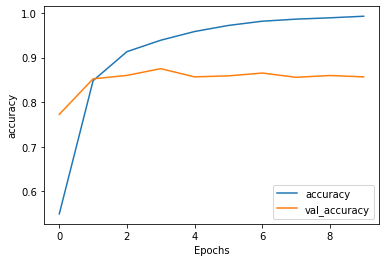

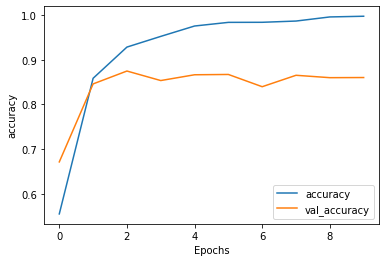

In [ ]:
plot_graphs(history, 'accuracy')
plot_graphs(history_TF, 'accuracy')

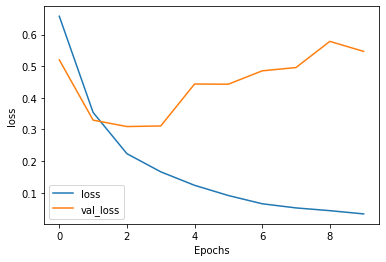

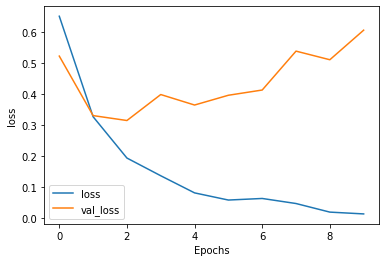

In [ ]:
plot_graphs(history, 'loss')
plot_graphs(history_TF, 'loss')

# Pruebas

In [ ]:
def pad_to_size(vec, size):
  zeros = [0] * (size - len(vec))
  vec.extend(zeros)
  return vec

In [ ]:
def sample_predict(sample_pred_text, pad, model=model_simple_Data):
  
  encoded_sample_pred_text = encoder.encode(sample_pred_text)

  if pad:
    encoded_sample_pred_text = pad_to_size(encoded_sample_pred_text, 64)
  encoded_sample_pred_text = tf.cast(encoded_sample_pred_text, tf.float32)
  predictions = model.predict(tf.expand_dims(encoded_sample_pred_text, 0))

  return (predictions)

In [ ]:
# predict on a sample text without padding.

sample_pred_text = ('The movie was cool. The animation and the graphics ' + 
                    'were out of this world. I would recommend this movie.')
predictions1 = sample_predict(sample_pred_text, pad=True, model= model_simple_Data)
predictions2 = sample_predict(sample_pred_text, pad=True, model = model_TF_Data)
print( "Plain Text: ",getSentiment(predictions1[0]) ,"\nTF DataSet: " ,getSentiment(predictions2))

Plain Text:  La opinión es positiva 
TF DataSet:  La opinión es negativa


In [ ]:
sample_pred_text = ('The movie was not good. The animation and the graphics '+
                    'were terrible. I would not recommend this movie.')
predictions1 = sample_predict(sample_pred_text, pad=True, model= model_simple_Data)
predictions2 = sample_predict(sample_pred_text, pad=True, model = model_TF_Data)

print( "Plain Text: ",getSentiment(predictions1[0]) ,"\nTF DataSet: " ,getSentiment(predictions2))

Plain Text:  La opinión es negativa 
TF DataSet:  La opinión es negativa


In [ ]:
sample_pred_text = ("""The speech is very mumbled and not clear. The audio dialogue needs remixing and the background score and effects need lowering in volume. The character builds are non-existent. The plot is predictable. Action and special effects are very good but not ground breaking in this age when anyone can really shoot HD and then play it back backwards. Needs a second watch with sub titles.""")
predictions1 = sample_predict(sample_pred_text, pad=True, model= model_simple_Data)
predictions2 = sample_predict(sample_pred_text, pad=True, model = model_TF_Data)
print( "Plain Text: ",getSentiment(predictions1[0]) ,"\nTF DataSet: " ,getSentiment(predictions2))

Plain Text:  La opinión es negativa 
TF DataSet:  La opinión es negativa


In [ ]:
sample_pred_text = ("""If I talk about acting, Then I have to say that Robert Pattinson has really proved himself as a very good actor in these recent years. And I am sure his acting skills will increase with time. His performance is charming and very smooth. Whenever he is on the camera, he steals the focus John David Washington is also fantastic in this movie. His performance is electrifying, I hope to see more from him in the future. Other characters such as Kenneth Branagh, Elizabeth, Himesh Patel, Dimple Kapadia, Clémence Poésy have also done quite well. And I dont think there is a need to talk about Michael Caine""")
predictions1 = sample_predict(sample_pred_text, pad=True, model= model_simple_Data)
predictions2 = sample_predict(sample_pred_text, pad=True, model = model_TF_Data)
print( "Plain Text: ",getSentiment(predictions1[0]) ,"\nTF DataSet: " ,getSentiment(predictions2))

Plain Text:  La opinión es positiva 
TF DataSet:  La opinión es positiva
